In [92]:
import xarray as xr
import PMMPIESM as PM
import glob
import numpy as np
import matplotlib.pyplot as plt

# Takahashi Decomposition

In [2]:
path = '/work/mh0727/m300524/experiments/results/'

In [30]:
tos = xr.open_dataarray(path+'control_tos_mm.nc')

/work/mh0727/m300524/anaconda3/envs/my_jupyter/lib/python3.6/site-packages/xarray/coding/times.py:122: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  result = decode_cf_datetime(example_value, units, calendar)
/work/mh0727/m300524/anaconda3/envs/my_jupyter/lib/python3.6/site-packages/xarray/coding/variables.py:69: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  return self.func(self.array)


In [31]:
spco2 = xr.open_dataarray(path+'control_spco2_mm.nc')*10

In [32]:
ds = xr.merge([tos,spco2])

In [41]:
def temp_decomp_takahashi(ds, time_dim='time'):
    """
    Decompose spco2 into thermal and non-thermal component.
    
    Reference
    ---------
    Takahashi, Taro, Stewart C. Sutherland, Colm Sweeney, Alain Poisson, Nicolas Metzl, Bronte Tilbrook,
    Nicolas Bates, et al. “Global Sea–Air CO2 Flux Based on Climatological Surface Ocean PCO2, and Seasonal
    Biological and Temperature Effects.” Deep Sea Research Part II: Topical Studies in Oceanography, The
    Southern Ocean I: Climatic Changes in the Cycle of Carbon in the Southern Ocean, 49, no. 9 (January 1,2002):
    1601–22. https://doi.org/10/dmk4f2.

    Input
    -----
    ds : xr.Dataset containing spco2[ppm] and tos[C or K]
        
    Output
    ------
    thermal, non_thermal : xr.DataArray
        thermal and non-thermal components in ppm units
        
    """
    fac = 0.0432
    tos_mean = ds['tos'].mean(time_dim)
    tos_diff = ds['tos'] - tos_mean
    thermal = ds['spco2'].mean(time_dim) * (np.exp(tos_diff * fac))
    non_thermal = ds['spco2'] * (np.exp(tos_diff * -fac))
    return thermal, non_thermal

In [34]:
thermal, non_thermal = temp_decomp_takahashi(ds)

/work/mh0727/m300524/anaconda3/envs/my_jupyter/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/work/mh0727/m300524/anaconda3/envs/my_jupyter/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [35]:
thermal_seasonality = thermal.groupby('time.month').mean('time')

/work/mh0727/m300524/anaconda3/envs/my_jupyter/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


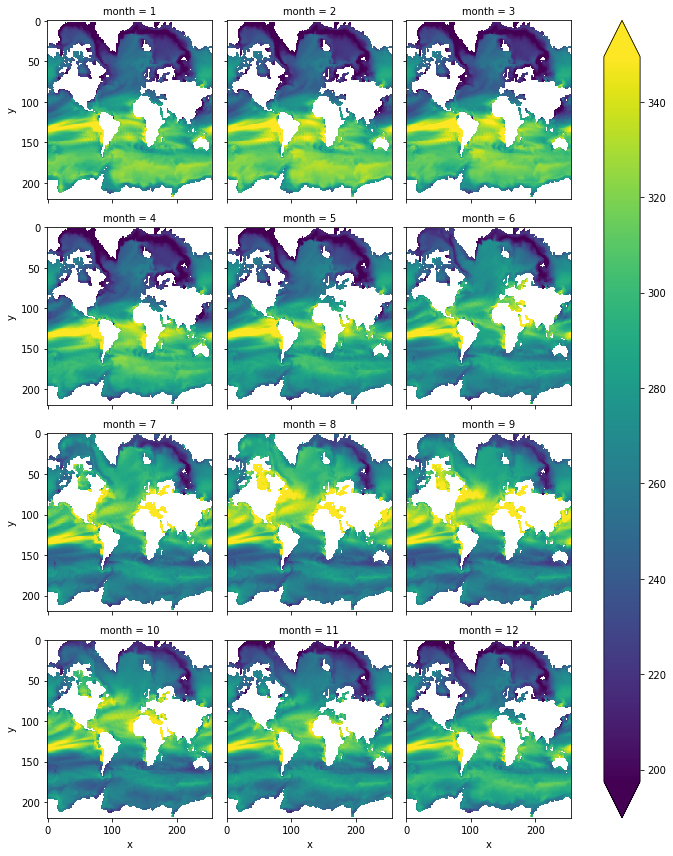

In [39]:
thermal_seasonality.plot(col='month',col_wrap=3, yincrease=False, robust=True)

In [37]:
non_thermal_seasonality = non_thermal.groupby('time.month').mean('time')

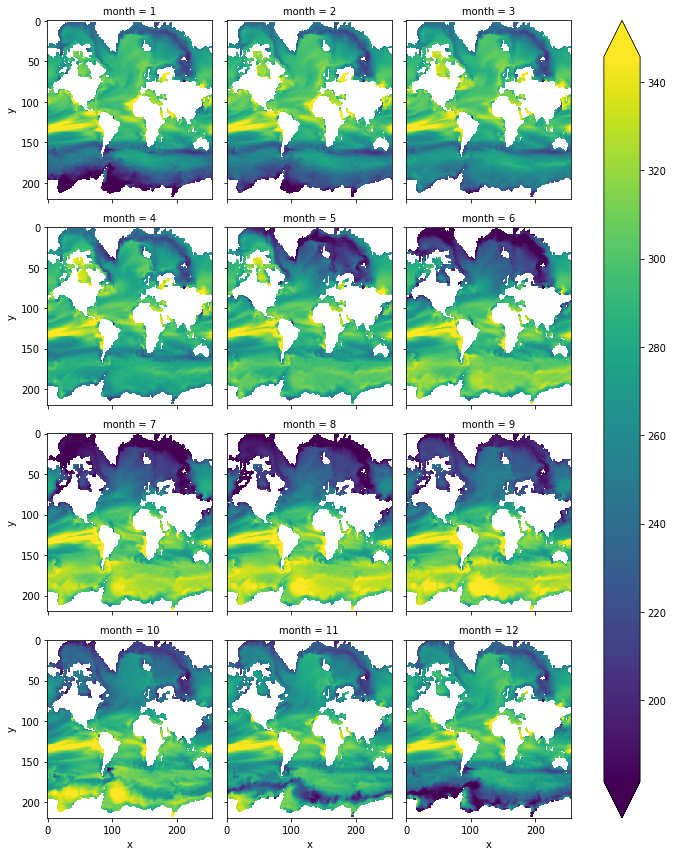

In [40]:
non_thermal_seasonality.plot(col='month',col_wrap=3, yincrease=False, robust=True)

# Potential pco2

In [7]:
h3d = xr.open_dataset('/work/mh0727/m300524/experiments/vga0214/outdata/hamocc/vga0214_hamocc_data_3d_mm_32920101_32921231.nc')

/work/mh0727/m300524/anaconda3/envs/my_jupyter/lib/python3.6/site-packages/xarray/coding/times.py:122: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  result = decode_cf_datetime(example_value, units, calendar)
/work/mh0727/m300524/anaconda3/envs/my_jupyter/lib/python3.6/site-packages/xarray/coding/variables.py:69: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  return self.func(self.array)


In [15]:
talk = h3d['talk']
dissic = h3d['dissic']

In [98]:
# dirty fix to get pco2_insitu
k=1
pco2_insitu = k*(2* dissic - talk)**2/(talk-dissic)

In [8]:
m3d = xr.open_dataset('/work/mh0727/m300524/experiments/vga0214/outdata/mpiom/vga0214_mpiom_data_3d_mm_32920101_32921231.nc')

In [10]:
t_insitu = m3d['thetao']

In [102]:
def potential_pco2(t_insitu, pco2_insitu):
    """
    Calculate potential pco2 in the inner ocean.
    
    Reference:
    - Sarmiento, Jorge Louis, and Nicolas Gruber. Ocean Biogeochemical Dynamics.
        Princeton, NJ: Princeton Univ. Press, 2006., p.421, eq. (10:3:1)

    """
    t_sfc = t_insitu.sel(depth=6)
    pco2_potential = pco2_insitu * (1 + 0.0423 * (t_sfc - t_insitu))
    return pco2_potential

In [62]:
pot_pco2 = potential_pco2(t_insitu, pco2_insitu)

/work/mh0727/m300524/anaconda3/envs/my_jupyter/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Text(0.5,1,'N-S section Pacific: Factor increase of potential_pCO2 compared to pCO2')

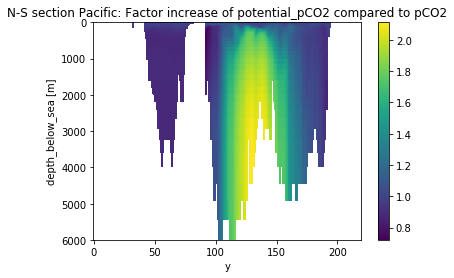

In [101]:
(pot_pco2/pco2_insitu).mean('time').isel(x=0).plot(yincrease=False)
plt.title('N-S section Pacific: Factor increase of potential_pCO2 compared to pCO2')